In [1]:
# Import libraries
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import os

In [2]:
# !unzip /content/Dataset.zip -d /content/extracted

In [3]:
# Load images
image_path = "./Dataset/"

images = []

for filename in os.listdir(image_path):
    img = tf.keras.preprocessing.image.load_img(f"{image_path}{filename}", target_size=(64, 64))
    img = tf.keras.preprocessing.image.img_to_array(img)
    images.append(img)

In [4]:
# Preprocess Images
images = np.asarray(images)

# Shuffle
indices = np.arange(images.shape[0])
np.random.shuffle(indices)
images = images[indices]

# Normalize
images = images.astype(np.float32) / 255.0

# Split dataset
total_data = len(images)
train_count = int(0.8 * total_data) # 80%

x_train = images[:train_count] # ambil 80% pertama
x_test = images[train_count : ] # ambil sisanya

print(f"Total Data: {total_data}")
print(f"Train: {x_train.shape}, Test: {x_test.shape}")

Total Data: 300
Train: (240, 64, 64, 3), Test: (60, 64, 64, 3)


In [5]:
BATCH_SIZE = 100
IMAGE_ORIGINAL_SHAPE = x_train.shape[1:]
IMAGE_SIZE = IMAGE_ORIGINAL_SHAPE[0] * IMAGE_ORIGINAL_SHAPE[1] * IMAGE_ORIGINAL_SHAPE[2]
HIDDEN_DIM = 512
LATENT_DIM = 32
MAX_EPOCHS = 60
LEARNING_RATE = 0.0001

print(IMAGE_ORIGINAL_SHAPE, IMAGE_SIZE)

(64, 64, 3) 12288


In [6]:
class VAE(tf.keras.Model):
    def __init__(self, dim, **kwargs):
        super(VAE, self).__init__(**kwargs)

        h_dim_1 = 512  # Hidden Layer 1 (Sesuai Diagram)
        h_dim_2 = 256  # Hidden Layer 2 (Sesuai Diagram)
        z_dim = dim[1] # Latent Dim (32)

        # --- ENCODER ---
        # Step 1: 12288 -> 512
        self.enc_dense1 = tf.keras.layers.Dense(h_dim_1, activation=tf.nn.relu)
        self.enc_bn1 = tf.keras.layers.BatchNormalization()
        self.enc_dropout1 = tf.keras.layers.Dropout(0.3) # Dropout rate standar

        # Step 2: 512 -> 256
        self.enc_dense2 = tf.keras.layers.Dense(h_dim_2, activation=tf.nn.relu)
        self.enc_bn2 = tf.keras.layers.BatchNormalization()
        self.enc_dropout2 = tf.keras.layers.Dropout(0.3)

        # Step 3: 256 -> 32 (Latent Space)
        self.enc_mu = tf.keras.layers.Dense(z_dim)      # Mean
        self.enc_log_var = tf.keras.layers.Dense(z_dim) # Log Variance

        # --- DECODER ---
        # Step 4: 32 -> 256
        self.dec_dense1 = tf.keras.layers.Dense(h_dim_2, activation=tf.nn.relu)
        self.dec_bn1 = tf.keras.layers.BatchNormalization()
        self.dec_dropout1 = tf.keras.layers.Dropout(0.3)

        # Step 5: 256 -> 512
        self.dec_dense2 = tf.keras.layers.Dense(h_dim_1, activation=tf.nn.relu)
        self.dec_bn2 = tf.keras.layers.BatchNormalization()

        # Step 6: 512 -> 12288 (Original Image Size)
        self.dec_out = tf.keras.layers.Dense(IMAGE_SIZE)
        self.dec_out_bn = tf.keras.layers.BatchNormalization() # Diagram menaruh BN di akhir

    def encode(self, x):
        # Layer 1 Process
        x = self.enc_dense1(x)
        x = self.enc_bn1(x)
        x = self.enc_dropout1(x)

        # Layer 2 Process
        x = self.enc_dense2(x)
        x = self.enc_bn2(x)
        x = self.enc_dropout2(x)

        return self.enc_mu(x), self.enc_log_var(x)

    def reparameterize(self, mu, log_var):
        std = tf.exp(log_var * 0.5)
        eps = tf.random.normal(tf.shape(std))
        return mu + eps * std

    def decode_logits(self, z):
        # Decoder Layer 1
        x = self.dec_dense1(z)
        x = self.dec_bn1(x)
        x = self.dec_dropout1(x)

        # Decoder Layer 2
        x = self.dec_dense2(x)
        x = self.dec_bn2(x)

        # Output Layer
        x = self.dec_out(x)
        return self.dec_out_bn(x) # Return logits (mentah) yang sudah di-BN

    def decode(self, z):
        return tf.nn.sigmoid(self.decode_logits(z))

    def call(self, inputs, training=None, mask=None):
        mu, log_var = self.encode(inputs)
        z = self.reparameterize(mu, log_var)
        x_recon_logits = self.decode_logits(z)
        return x_recon_logits, mu, log_var

In [7]:
# Model initialization
model = VAE([HIDDEN_DIM, LATENT_DIM])

dummy = tf.zeros((BATCH_SIZE, IMAGE_SIZE))
model(dummy)

model.summary()

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

dataset = tf.data.Dataset.from_tensor_slices(x_train)
dataset = dataset.shuffle(BATCH_SIZE * 5).batch(BATCH_SIZE)

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  6291968   
                                                                 
 batch_normalization (BatchN  multiple                 2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 dense_1 (Dense)             multiple                  131328    
                                                                 
 batch_normalization_1 (Batc  multiple                 1024      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         multiple                  0       

In [8]:
# Train model
loss_history = []
kl_div_history = []

for epoch in range(MAX_EPOCHS):
    for x in dataset:
        x = tf.reshape(x, [-1, IMAGE_SIZE])
        with tf.GradientTape() as tape:

            x_reconstruction_logits, mu, log_var = model(x)

            reconstruction_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=x, logits=x_reconstruction_logits)
            reconstruction_loss = tf.reduce_sum(reconstruction_loss) / BATCH_SIZE

            kl_div = -0.5 * tf.reduce_sum(1. + log_var - tf.square(mu) - tf.exp(log_var), axis = -1)
            kl_div = tf.reduce_mean(kl_div)

            loss = tf.reduce_mean(reconstruction_loss + kl_div)

        gradients = tape.gradient(loss, model.trainable_variables)
        gradients = [tf.clip_by_norm(g, 15) for g in gradients]

        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    print(f"Epoch[{epoch+1}/{MAX_EPOCHS}] Reconstruction Loss: {float(reconstruction_loss):.2f}, KL DIV: {float(kl_div):.2f}, Loss : {float(loss):.2f}")
    kl_div_history.append(kl_div)
    loss_history.append(loss)

Epoch[1/60] Reconstruction Loss: 3394.70, KL DIV: 2.76, Loss : 3397.46
Epoch[2/60] Reconstruction Loss: 3364.22, KL DIV: 10.40, Loss : 3374.62
Epoch[3/60] Reconstruction Loss: 3302.30, KL DIV: 30.06, Loss : 3332.36
Epoch[4/60] Reconstruction Loss: 3205.06, KL DIV: 78.28, Loss : 3283.34
Epoch[5/60] Reconstruction Loss: 3106.04, KL DIV: 139.83, Loss : 3245.87
Epoch[6/60] Reconstruction Loss: 2993.05, KL DIV: 181.41, Loss : 3174.46
Epoch[7/60] Reconstruction Loss: 2933.97, KL DIV: 200.30, Loss : 3134.27
Epoch[8/60] Reconstruction Loss: 2871.83, KL DIV: 164.89, Loss : 3036.72
Epoch[9/60] Reconstruction Loss: 2840.19, KL DIV: 143.23, Loss : 2983.42
Epoch[10/60] Reconstruction Loss: 2833.62, KL DIV: 134.49, Loss : 2968.10
Epoch[11/60] Reconstruction Loss: 2778.93, KL DIV: 122.81, Loss : 2901.74
Epoch[12/60] Reconstruction Loss: 2759.04, KL DIV: 100.53, Loss : 2859.58
Epoch[13/60] Reconstruction Loss: 2754.01, KL DIV: 92.21, Loss : 2846.21
Epoch[14/60] Reconstruction Loss: 2725.61, KL DIV: 96

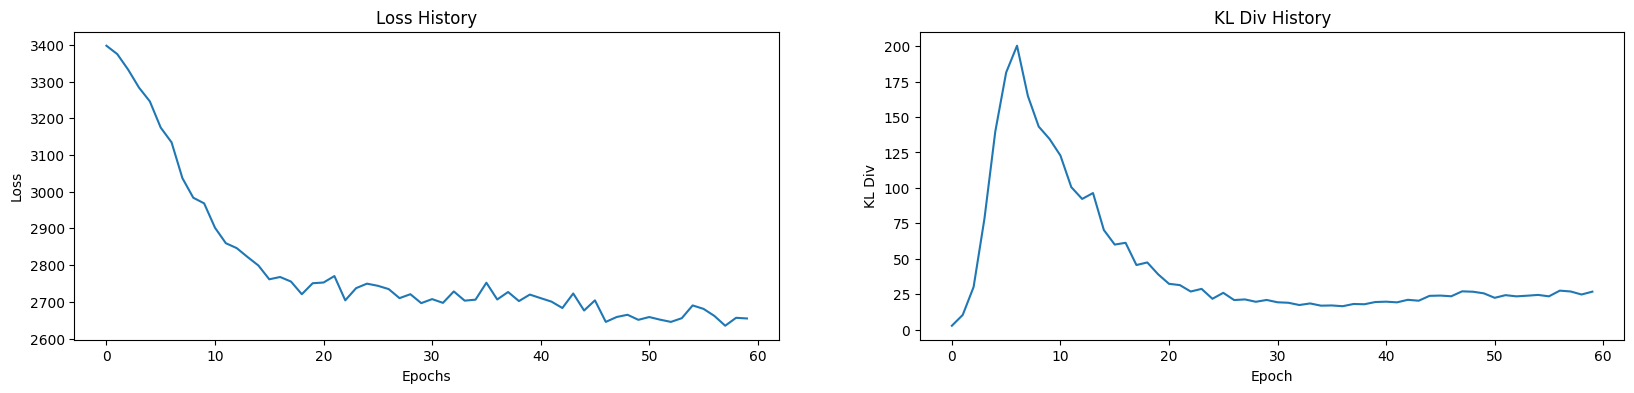

In [9]:
# Plotting
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
plt.plot(loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss History")

plt.subplot(1,2,2)
plt.plot(kl_div_history)
plt.xlabel("Epoch")
plt.ylabel("KL Div")
plt.title("KL Div History")

plt.show()

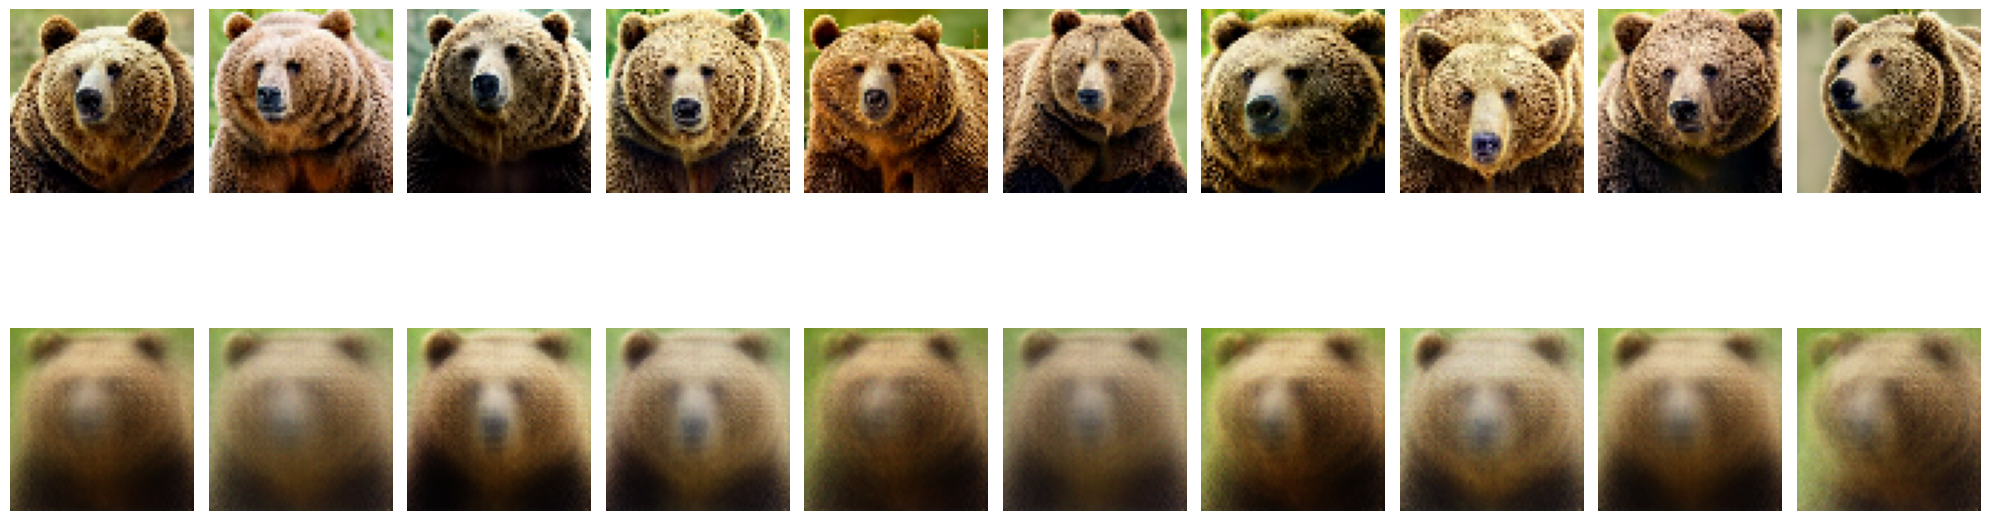

In [10]:
# Implement model for reconstruction test data
mu, log_var = model.encode(x_test.reshape(-1, IMAGE_SIZE))
z = model.reparameterize(mu, log_var)

out = model.decode(z)
out = tf.reshape(out, [-1, IMAGE_ORIGINAL_SHAPE[0], IMAGE_ORIGINAL_SHAPE[1], IMAGE_ORIGINAL_SHAPE[2]]).numpy() * 255
out = out.astype(np.uint8)

number = 10
plt.figure(figsize=(20, 8))

for index in range(number):
    ax = plt.subplot(2, number, index+1)
    plt.imshow(x_test[index].reshape(64, 64, 3))
    ax.axis('off')

for index in range(number):
    ax = plt.subplot(2, number, number + index + 1)
    plt.imshow(out[index])
    ax.axis('off')

plt.tight_layout()
plt.show()